# Weighted Global Average Tutorial 
### Authors

Fletcher Hozven fhozven@ucsb.edu

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Required Packages](#Import)

[Read in Data](#Path)

[Weight Grid Cells by Area](#weight)

[Calculate the Global Average Temperature](#global)

[Calculate Yearly Means](#year)

[Plot the Weighted Global Temperature](#plot)

[Compare Weighted vs Unweighted Temperature](#compare)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will be going over how to create a global average temperature plot, where the average has been weighted according to the area of each grid cell. If you have already worked through tutorial 1. "Read in Climate Data + Plotting a Time Series" in this repo, much of the content is similar - the main difference is that we will be focusing on applying area weights to make the average more representative.

_What is a Global Average Plot?_

A global average plot is a visual representation of the average value of a specific variable across the entire Earth's surface, plotted over time. The plot shows how the global average of that variable changes over a period, often used to monitor climate trends like rising global temperatures.

_Why weight the grid cells?_

- The Earth is a sphere, so if grid size is specified by angle, that means that grid cells near the poles are physically smaller than those at the equator.
- This happens because the size of the latitudinal circles shrinks as you move toward the poles, based on the cosine of the latitude.
- Weighting ensures these smaller cells are properly represented in the global average.
- When plotting large areas like the global temperature these weights are necessary in order for certain areas not to be artifically over- or undercounted.

 __The image below depicts how grid cell sizes change as you go from the poles --> to the --> equator__

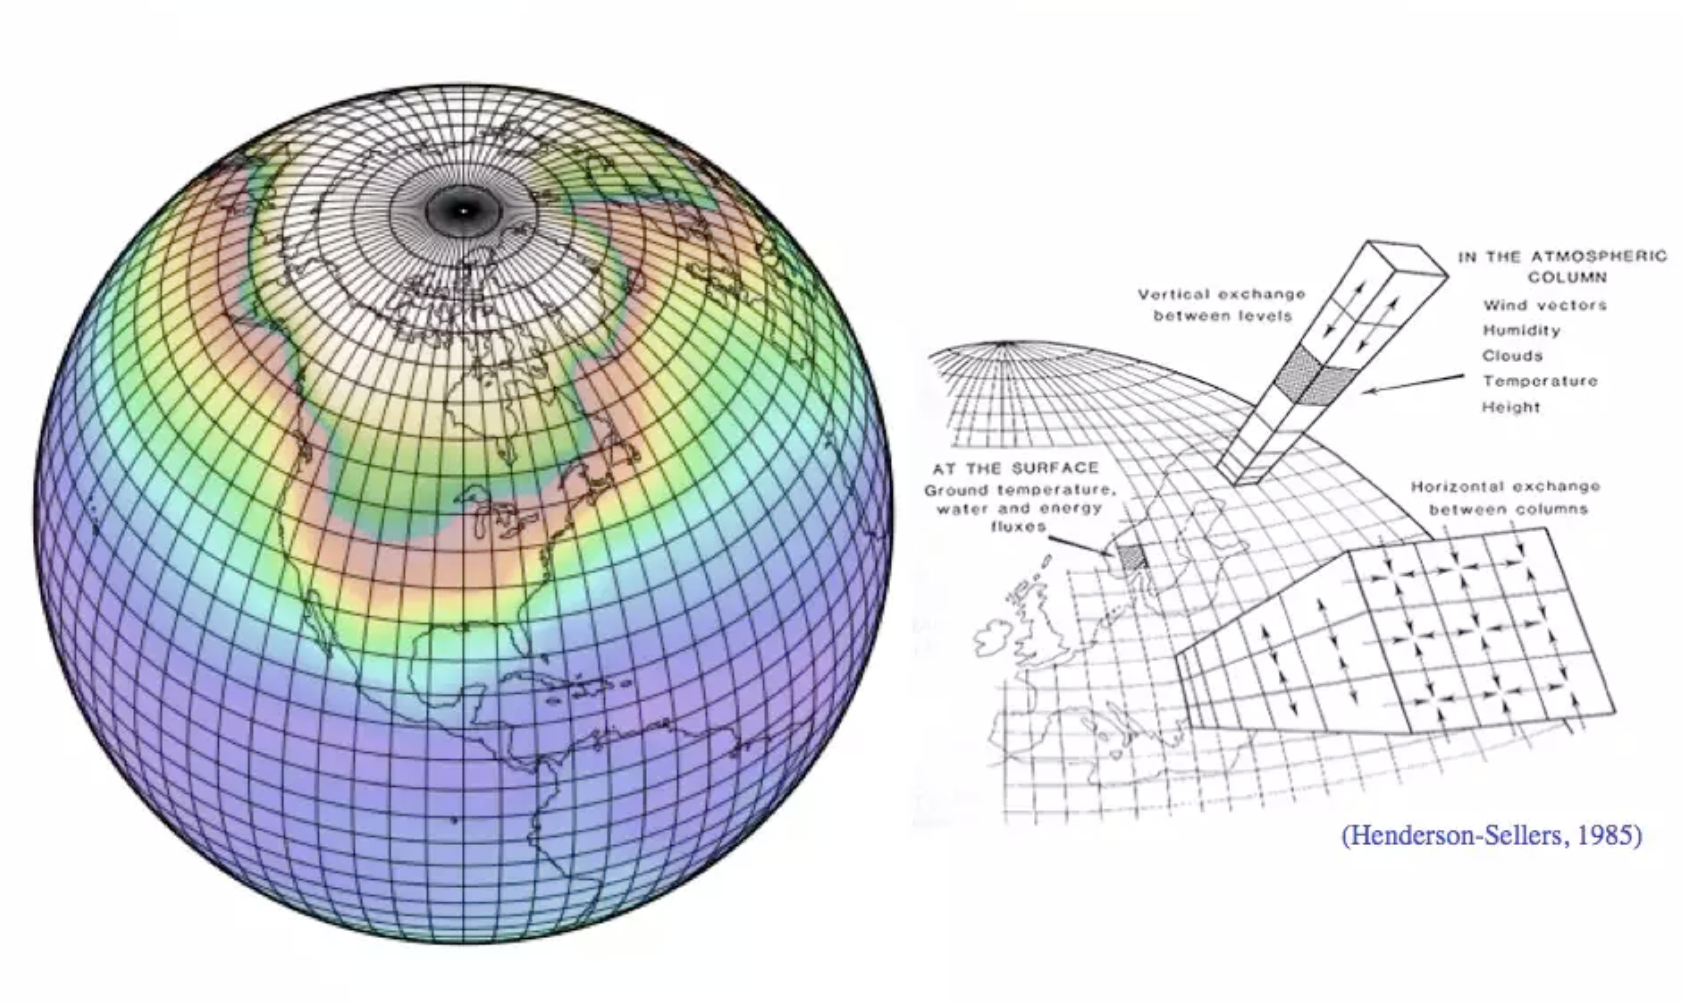

<a id='Import'></a> 
## **Import Required Packages**

In [132]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

##### Remember from earlier tutorials we import these packages because...
- ##### `xarray` can read and write NetCDF files
- ##### `matplotlib` is a plotting library that will be used to plot maps and geospatial data
- ##### `numpy` is used for working with arrays and will help us create our line of best fit

If the above packages are not included in your Python environment, use `conda install` to install them (see tutorial 1 for details).

<a id='Path'></a> 
## **Read in Data**

##### We will be using the xarray to open our climate file 
- ##### `xr.open_dataset` will open our netcdf file into jupyter notebook
- ##### `data` will open our data set and depict our climate data information

In [136]:
data = xr.open_dataset('/Users/fletcherhoz/Desktop/tas_Amon_BCC-CSM2-MR_amip-future4K_r1i1p1f1_gn_197901-201412.nc')

- `tas` variable is seen above the the data as the variable for near surface air temperature
- Set a name for `data.tas` so it is easier to write down later!

In [177]:
temp_data = data.tas -273.15
temp_data

<xarray.DataArray 'tas' (time: 432, lat: 160, lon: 320)>
array([[[-19.844803 , -19.833145 , -19.841217 , ..., -19.826172 ,
         -19.833038 , -19.822067 ],
        [-18.996338 , -19.004303 , -19.011932 , ..., -18.960083 ,
         -18.97293  , -18.983154 ],
        [-18.48677  , -18.506775 , -18.526642 , ..., -18.430222 ,
         -18.449646 , -18.467773 ],
        ...,
        [-23.19931  , -23.167221 , -23.05751  , ..., -23.205048 ,
         -23.197678 , -23.21074  ],
        [-24.273087 , -24.298248 , -24.32225  , ..., -24.174713 ,
         -24.212082 , -24.243118 ],
        [-24.05133  , -24.077469 , -24.012512 , ..., -23.966675 ,
         -23.982742 , -23.993164 ]],

       [[-32.930984 , -32.950607 , -32.970108 , ..., -32.879562 ,
         -32.92296  , -32.920654 ],
        [-31.506226 , -31.539383 , -31.57277  , ..., -31.398499 ,
         -31.431412 , -31.460571 ],
        [-30.647049 , -30.699203 , -30.753311 , ..., -30.443893 ,
         -30.515    , -30.58345  ],
...
        [ -9.763245 ,  -9.749603 ,  -9.743713 , ...,  -9.799652 ,
          -9.732361 ,  -9.719421 ],
        [ -9.3828125,  -9.38504  ,  -9.396423 , ...,  -9.340271 ,
          -9.34729  ,  -9.365875 ],
        [ -8.491638 ,  -8.4904175,  -8.498444 , ...,  -8.483398 ,
          -8.484619 ,  -8.487915 ]],

       [[-20.065826 , -20.084595 , -20.097107 , ..., -20.01358  ,
         -20.030807 , -20.047638 ],
        [-19.52948  , -19.578705 , -19.624878 , ..., -19.383774 ,
         -19.429535 , -19.479187 ],
        [-19.225449 , -19.306488 , -19.386429 , ..., -18.974915 ,
         -19.059433 , -19.145706 ],
        ...,
        [-14.996735 , -14.94751  , -14.822723 , ..., -15.232758 ,
         -15.201447 , -15.149231 ],
        [-14.820435 , -14.796234 , -14.775482 , ..., -14.854126 ,
         -14.829834 , -14.81665  ],
        [-13.185028 , -13.192566 , -13.185852 , ..., -13.171692 ,
         -13.162537 , -13.163055 ]]], dtype=float32)
Coordinates:
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
    height   float64 ...

<a id='weight'></a>
## **Weigh the grid cells (`def weights(w)`)**

As previosuly stated, when using data over a large area over the globe you need to weigh the grid cells in order to ensure accuracy.
- We will weigh the grid cells by creatig a weighing function by using `def` and `return` functions
- We will call the functions `weights(w)`
- `np.cos(np.deg2rad(w.lat))` is calucltaing the cosine of latitude
-  ` coslat / coslat.mean(dim='lat')` is normalize weights by the mean
-  `return computed_weight` is returning the real value of the weighted grid cells

In [195]:
def weights(w):
    coslat = np.cos(np.deg2rad(w.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    computed_weight = w * weight_factor
    return computed_weight

<a id='weights'></a>
## **Apply the `weights`**
Apply the newly created function `weights` to the temperature data

In [198]:
weighted_temp = weights(temp_data)
weighted_temp

<xarray.DataArray (time: 432, lat: 160, lon: 320)>
array([[[-0.46557731, -0.46530381, -0.46549318, ..., -0.46514021,
         -0.4653013 , -0.46504391],
        [-1.02283876, -1.02326763, -1.02367843, ..., -1.02088665,
         -1.02157843, -1.0221289 ],
        [-1.56002493, -1.56171301, -1.5633895 , ..., -1.55525298,
         -1.55689213, -1.55842183],
        ...,
        [-1.95769738, -1.95498949, -1.94573145, ..., -1.95818152,
         -1.9575596 , -1.95866181],
        [-1.30696   , -1.3083148 , -1.30960717, ..., -1.30166318,
         -1.30367526, -1.30534638],
        [-0.56426632, -0.56487954, -0.5633556 , ..., -0.56228021,
         -0.56265717, -0.56290168]],

       [[-0.77259116, -0.77305153, -0.77350903, ..., -0.77138475,
         -0.77240286, -0.7723488 ],
        [-1.69642111, -1.69820643, -1.70000408, ..., -1.69062066,
         -1.69239283, -1.6939629 ],
        [-2.58618237, -2.59058348, -2.59514941, ..., -2.56903889,
         -2.57503923, -2.58081554],
...
        [-0.82388132, -0.82273018, -0.82223316, ..., -0.8269536 ,
         -0.82127516, -0.82018325],
        [-0.50520813, -0.50532808, -0.50594099, ..., -0.50291752,
         -0.50329546, -0.50429616],
        [-0.19922163, -0.199193  , -0.1993813 , ..., -0.19902832,
         -0.19905696, -0.19913429]],

       [[-0.47076273, -0.47120305, -0.4714966 , ..., -0.46953699,
         -0.46994115, -0.47033601],
        [-1.05154526, -1.05419572, -1.05668187, ..., -1.04369986,
         -1.04616382, -1.04883728],
        [-1.62235902, -1.62919761, -1.6359435 , ..., -1.60121745,
         -1.60834962, -1.61562987],
        ...,
        [-1.26551469, -1.2613608 , -1.25083058, ..., -1.28543173,
         -1.28278951, -1.27838325],
        [-0.79799143, -0.79668838, -0.79557102, ..., -0.79980551,
         -0.79849753, -0.79778768],
        [-0.30933287, -0.30950972, -0.30935221, ..., -0.30902   ,
         -0.3088052 , -0.30881738]]])
Coordinates:
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
    height   float64 2.0

<a id='global'></a>
## **Calculate the Global Average Temperature**
- `weighted_global_temp` is defined by taking out the near surface air temperature values from the `data` by using the `.mean` function
- The `(dim=['lat', 'lon'])` averages the temperature data over all the latitude and longitude points within the globe and turns it into a DataArray

__Since the world is immense it is cruical that we weighed the grid cells in order for accurate values__

In [186]:
weighted_global_temp = weighted_temp.mean(dim=['lat', 'lon'])

<a id='convert'></a>
## **Convert to Celsius**

To convert from Kelvin to Celsius, subtract 273.15 from the temperature values.

In [189]:
weighted_global_temp_c = weighted_global_temp - 273.15

<a id='year'></a>
## **Calculate yearly temperature means & extract values**
-  `.groupby('time.year')` Groups the data by each year.
-  `.mean()` Computes the mean temperature for each year.
- The `yearly_weighted_global_temp` variable now holds the average global temperature for each year, which can be used to observe long-term trends.

In [192]:
yearly_weighted_global_temp = weighted_global_temp_c.groupby('time.year').mean()
yearly_weighted_global_temp

<xarray.DataArray (year: 36)>
array([-254.16689907, -254.15405817, -254.19697611, -254.25016726,
       -254.05764849, -254.11506875, -254.28648158, -254.24147853,
       -253.983417  , -254.13205647, -254.16655483, -253.96558685,
       -253.9301945 , -254.13470253, -254.21587221, -254.05966209,
       -253.92882661, -253.99206098, -253.79665486, -253.66175891,
       -254.04392602, -254.01453429, -253.88511122, -253.76495711,
       -253.71711596, -253.72720677, -253.60857797, -253.73994241,
       -253.80446361, -253.96133641, -253.78794831, -253.72573654,
       -254.00888631, -253.92704342, -253.6838887 , -253.61673604])
Coordinates:
    height   float64 2.0
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014

<a id='plot'></a>
## **Plot the Weighted Global Temperature !**
- We plot the unweighted Global average surface air temperature from 2000 to 2014 to see how temperatures value look__
- For more info on plotting look at previous tutorials on https://climate-datalab.org/

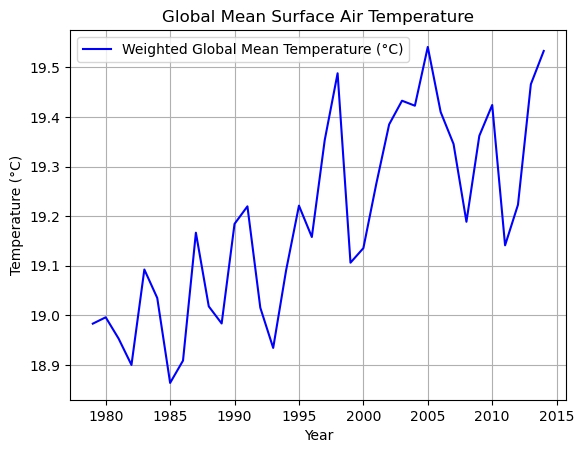

In [150]:
plt.figure()
plt.plot(yearly_weighted_global_temp.year, yearly_weighted_global_temp, label='Weighted Global Mean Temperature (°C)', color='blue')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Global Mean Surface Air Temperature')
plt.legend()
plt.grid()
plt.show()

<a id='unweight'></a>
## **Unweighted plot**
 __Lets go now compare our plot to an unweighted plot and see how much our values varry__
- Repeating every step the same way execpt skipping the weights function

In [152]:
unweighted_global_temp = temp_data.mean(dim=['lat', 'lon']) 
unweighted_global_temp = unweighted_global_temp - 273.15 
yearly_unweighted_global_temp = unweighted_global_temp.groupby('time.year').mean() 

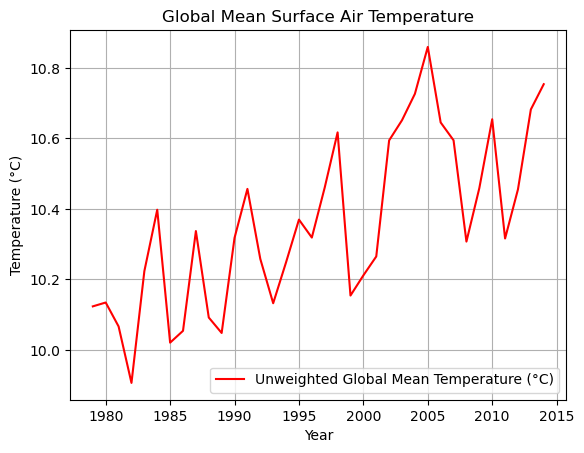

In [153]:
plt.figure()
plt.plot(yearly_unweighted_global_temp.year, yearly_unweighted_global_temp, label='Unweighted Global Mean Temperature (°C)', color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Global Mean Surface Air Temperature')
plt.legend()
plt.grid()
plt.show()

#### We can see here how the temperature values are low!!! The global average temperature should be roughly 15 °C

<a id='compare'></a>
## **Compare weighted vs unweighted plot**

Now lets use this unweighted data and plot and compare the two different datasets to better visualize the difference in weights

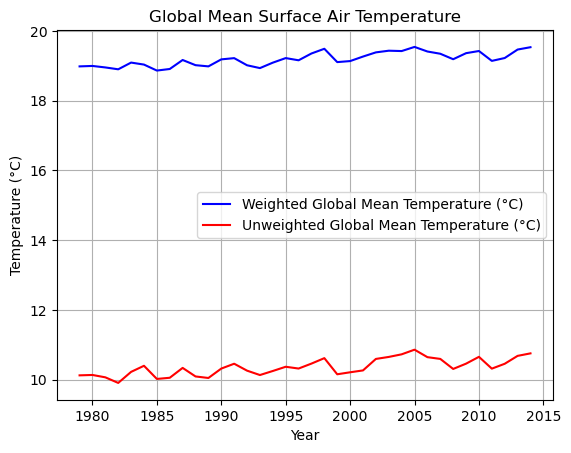

In [156]:
plt.figure()
plt.plot(yearly_weighted_global_temp.year, yearly_weighted_global_temp, label='Weighted Global Mean Temperature (°C)', color='blue')
plt.plot(yearly_unweighted_global_temp.year, yearly_unweighted_global_temp, label='Unweighted Global Mean Temperature (°C)', color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Global Mean Surface Air Temperature')
plt.legend()
plt.grid()
plt.show()

__We can look at these two values side by side to better compare how much the wieghts imporve the accuracy of the global temperature data !__

__Tutorial Finished !! Happy Plotting !__